# Detección de Aves de la Selva Misionera con YOLOv5



*Ejemplo de Transferencia de Aprendizaje en Redes Neuronales Artificiales*


**CONTEXTO a tratar:**

Suponga que un experto (https://www.youtube.com/c/SergioMoyaBioAudioVisual) le proporciona imágenes de especies poco frecuentes de avistar, son locales y por lo tanto no existen muchos registros.

La idea es detectar si este tipo de aves aparecen dentro de los videos/fotografías tomadas por las cámaras trampa distribuidas en una reserva protegida. Se tienen registros de varios años, por lo tanto, muchos GB de información a procesar.

La idea es obtener un modelo que permita facilitar esta ardua tarea.

**Ejemplo:**


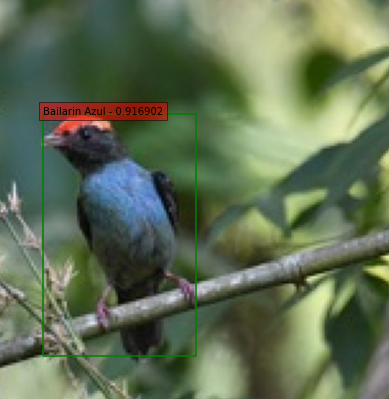


**POSIBLE SOLUCIÓN:**

Utilizar una RNA, pero al disponer de pocas imágenes clasificadas con certeza, el proceso de entrenar una red desde cero y con las capacidades solicitadas... se torna inviable.

Podemos utilizar una RNA ya entrenada para una tarea similar, agregar algunas capas para satisfacer nuestras necesidades, y entrenar estas últimas con nuestro dataset reducido.


**Información adicional:**


*   You Only Look Once (YOLO)
*   https://docs.ultralytics.com/
*   https://github.com/ultralytics/yolov5


**¿Aplicaciones en Ingeniería?**

Lo charlamos después de ver algunos resultados 🦾

## (1) Dataset

En este dataset hay imágenes a color de 8 tipos de aves misioneras. El tamaño de cada imagen es de 256x256 pixeles.
A su vez, cada imagen presenta codificadas las etiquetas correspondientes para la identificación de las aves.

In [ ]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Version Online
!wget https://github.com/AxelSkrauba/Monitoreo-Selva-Atlantica-Misionera/raw/main/Deteccion-Arboles-Muertos/data_v1.zip

--2022-10-06 11:51:34--  https://github.com/AxelSkrauba/Monitoreo-Selva-Atlantica-Misionera/raw/main/Deteccion-Arboles-Muertos/data_v1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AxelSkrauba/Monitoreo-Selva-Atlantica-Misionera/main/Deteccion-Arboles-Muertos/data_v1.zip [following]
--2022-10-06 11:51:35--  https://raw.githubusercontent.com/AxelSkrauba/Monitoreo-Selva-Atlantica-Misionera/main/Deteccion-Arboles-Muertos/data_v1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77621546 (74M) [application/zip]
Saving to: ‘data_v1.zip’

data_v1.zip         100%[===================>]  74.

In [ ]:
!unzip data_v1.zip

Archive:  data_v1.zip
   creating: Images/
  inflating: Images/DJI_0102_0.jpg   
  inflating: Images/DJI_0102_1.jpg   
  inflating: Images/DJI_0102_10.jpg  
  inflating: Images/DJI_0102_100.jpg  
  inflating: Images/DJI_0102_101.jpg  
  inflating: Images/DJI_0102_102.jpg  
  inflating: Images/DJI_0102_103.jpg  
  inflating: Images/DJI_0102_104.jpg  
  inflating: Images/DJI_0102_105.jpg  
  inflating: Images/DJI_0102_106.jpg  
  inflating: Images/DJI_0102_107.jpg  
  inflating: Images/DJI_0102_11.jpg  
  inflating: Images/DJI_0102_12.jpg  
  inflating: Images/DJI_0102_13.jpg  
  inflating: Images/DJI_0102_14.jpg  
  inflating: Images/DJI_0102_15.jpg  
  inflating: Images/DJI_0102_16.jpg  
  inflating: Images/DJI_0102_17.jpg  
  inflating: Images/DJI_0102_18.jpg  
  inflating: Images/DJI_0102_19.jpg  
  inflating: Images/DJI_0102_2.jpg   
  inflating: Images/DJI_0102_20.jpg  
  inflating: Images/DJI_0102_21.jpg  
  inflating: Images/DJI_0102_22.jpg  
  inflating: Images/DJI_0102_23.jpg  

## (2) Definición de Train/Val/Test data

Es necesario dividir las imágenes de nuestro dataset en training, validation y testing. En este paso se copian las imágenes (con sus archivos de texto de los labels correspondientes) en los siguientes directorios.
Esto se realiza de esta forma, porque YoLo espera una estructura similar.

```
data
   |——————images
   |        └——————train —— <trainimage01>.jpg
   |        |               <trainimage02>.jpg
   |        |                      :
   |        └——————val   —— <valimage01>.jpg
   |        |               <valimage02>.jpg
   |        |                      :
   |        └——————test —— <testimage01>.jpg
   |        |               <testimage02>.jpg
   |        |                      :
   └——————labels
   |        └——————train —— <trainimage01>.txt
   |        |               <trainimage02>.txt
   |        |                      :
   |        └——————val   —— <valimage01>.txt
   |        |               <valimage02>.txt
   |        |                      :
   |        └——————test —— <testimage01>.txt
   |        |               <testimage02>.txt
   |        |                      :
```


In [ ]:
!mkdir data
!mkdir data/images
!mkdir data/images/train
!mkdir data/images/val
!mkdir data/images/test
!mkdir data/labels
!mkdir data/labels/train
!mkdir data/labels/val
!mkdir data/labels/test

In [ ]:
from tqdm.auto import tqdm
import os, fnmatch

def dirfiles(img_path,img_ext):
    img_names = fnmatch.filter(sorted(os.listdir(img_path)),img_ext)
    return img_names


In [ ]:
import numpy as np
SEED = 777
np.random.seed(SEED)


p_train = 0.80  # 70% del total de los datos son training
p_val   = 0.20  # 10% de los datos de training son de validación


d = dirfiles('Images/','*.jpg')
m = len(d) # número de imagenes

nt = round(p_train*m)
nv = round(p_val*nt)

ii = np.vstack([np.zeros((nt-nv,1)),np.ones((nv,1)),2*np.ones((m-nt,1))])
np.random.shuffle(ii) # Aleatorio


target = ['train','val','test']

for i in tqdm(range(m)):
  fname            = d[i]
  tname            = fname[:-3]+'txt'
  ti               = target[int(ii[i])]
  source_file      = 'Images/'+fname
  destination_file = 'data/images/'+ti 
  os.system('cp ' + source_file + ' ' + destination_file) 
  source_file      = 'Labels/'+tname
  destination_file = 'data/labels/'+ti 
  os.system('cp ' + source_file + ' ' + destination_file) 

print('Training: ', nt-nv)
print('     Val: ', nv)
print(' Testing: ',m-nt)


  0%|          | 0/1296 [00:00<?, ?it/s]

Training:  830
     Val:  207
 Testing:  259


## (3) Definición de archivo YAML

Es necesario definir el archivo `data/data.yaml` que contiene la información de: 

* los directorios de training, validation y testing

* el nombre de las clases

* el número de clases

In [ ]:
# Nueva version de YOLO, salió hace poquito. A veces cambia la estructura base. Puede que en un futuro no funcione como está
PATH_ROOT = 'data'
PATH_TRAIN = 'images/train'
PATH_VAL   = 'images/val'
PATH_TEST  = 'images/test'
N_CLASSES  = 1 # Comienza en 0 las class labels. Rango entre 0 y nc-1.

class_names = ['Árboles Muertos']

f = open('data/data.yaml','w+')

f.write('path: ../'+PATH_ROOT+'\n')
f.write('train: '+PATH_TRAIN+'\n')
f.write('val: '+PATH_VAL+'\n')
f.write('test: '+PATH_TEST+'\n')
f.write('nc: '+str(N_CLASSES)+'\n')
f.write('names: '+str(class_names)+'\n')

f.close()

In [ ]:
!cat data/data.yaml

path: ../data
train: images/train
val: images/val
test: images/test
nc: 1
names: ['Árboles Muertos']


# YOLOv5

Una vez definida la base de datos, los subsets de training, testing y validación, con las anotaciones de los objetos a detectar en el formato requerido por YOLOv5 se procede a entrenar. Para esto necesitamos instalar la librería [YOLOv5](https://github.com/ultralytics/yolov5) desarrollada por Ultralytics.

## Instalación

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     |████████████████████████████████| 1.6 MB 43.3 MB/s 


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13441, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 13441 (delta 177), reused 228 (delta 167), pack-reused 13198
Receiving objects: 100% (13441/13441), 13.24 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (9236/9236), done.


In [ ]:
!pip install -qr yolov5/requirements.txt  # install dependencies (ignore errors)

In [54]:
pwd

'/root'

In [79]:
%cd yolov5

/content/yolov5


## Definiciones

In [75]:
YOLO_MODEL     = 'yolov5l' # puede ser yolov5n yolov5s yolov5m, yolov5l, yolov5x. Hay diferentes tamaños disponibles.
EPOCHS         = 200
CFG            = YOLO_MODEL+'.yaml'
TRAIN_WEIGHTS  = YOLO_MODEL+'.pt'  # o pesos de otro modelo propio pre-entrenado
BATCH          = 40 # original 8
IMG_SIZE       = 333
YAMLFILE       = '../data/data.yaml'

## Entrenamiento



In [80]:
!python train.py --img {IMG_SIZE} --batch {BATCH} --epochs {EPOCHS} --data {YAMLFILE} --cfg {CFG} --weights {TRAIN_WEIGHTS} --nosave --cache

train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=../data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=40, imgsz=333, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

## Detección en el testing

In [81]:
TEST_WEIGHTS = 'runs/train/exp3/weights/last.pt'  # ver path en las ultimas lineas de la ejecución anterior
PATH_TEST    = '../data/images/test'

In [82]:
!python detect.py --weights {TEST_WEIGHTS} --img 333 --conf 0.5 --source  {PATH_TEST} --save-txt --save-conf

detect: weights=['runs/train/exp3/weights/last.pt'], source=../data/images/test, data=data/coco128.yaml, imgsz=[333, 333], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
WARNING ⚠️ --img-size [333, 333] must be multiple of max stride 32, updating to [352, 352]
image 1/259 /content/data/images/test/DJI_0102_1.jpg: 352x352 (no detections), 24.8ms
image 2/259 /content/data/images/test/DJI_0102_103.jpg: 352x352 (no detections), 24.9ms
image 3/259 /content/data/images/test/DJI_0102_104.jpg: 352x352 (no detections)

## Estadísticas en validación

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --conf 0.7 --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --half

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=333, conf_thres=0.7, iou_thres=0.25, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
WARNING ⚠️ confidence threshold 0.7 > 0.001 produces invalid results
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 333 must be multiple of max stride 32, updating to 352
val: Scanning '/content/data/labels/val.cache' images and labels... 90 found, 117 missing, 5 empty, 0 corrupt: 100% 207/207 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 7/7 [00:02<00:00,  3.40it/s]
                   all        207        207      0.

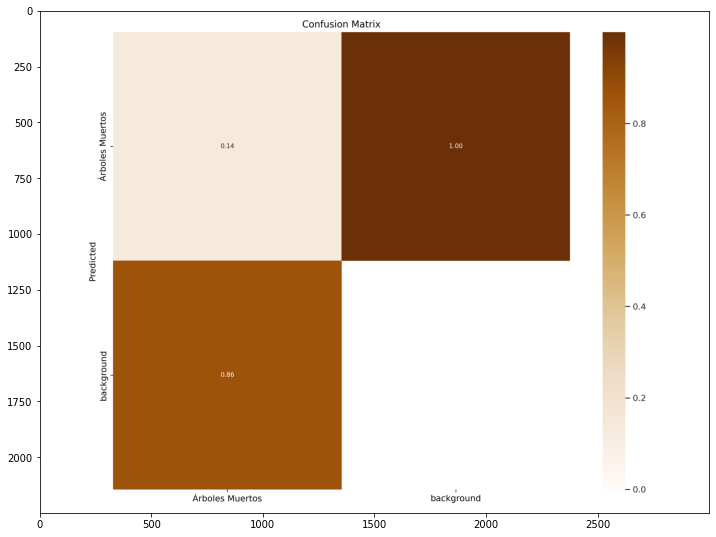

In [ ]:
import cv2
import matplotlib.pyplot as plt

I = cv2.imread('runs/val/exp/confusion_matrix.png') # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

## Estadísticas en testing

In [ ]:
!python val.py --weights {TEST_WEIGHTS} --data {YAMLFILE} --img {IMG_SIZE} --iou 0.25 --task test

val: data=../data/data.yaml, weights=['runs/train/exp/weights/last.pt'], batch_size=32, imgsz=333, conf_thres=0.001, iou_thres=0.25, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-186-g7f097dd Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size 333 must be multiple of max stride 32, updating to 352
test: Scanning '/content/data/labels/test' images and labels...130 found, 129 missing, 5 empty, 0 corrupt: 100% 259/259 [00:00<00:00, 2593.63it/s]
test: New cache created: /content/data/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 9/9 [00:02<00:00,  3.53it/s]
                   all        259        287      0.44

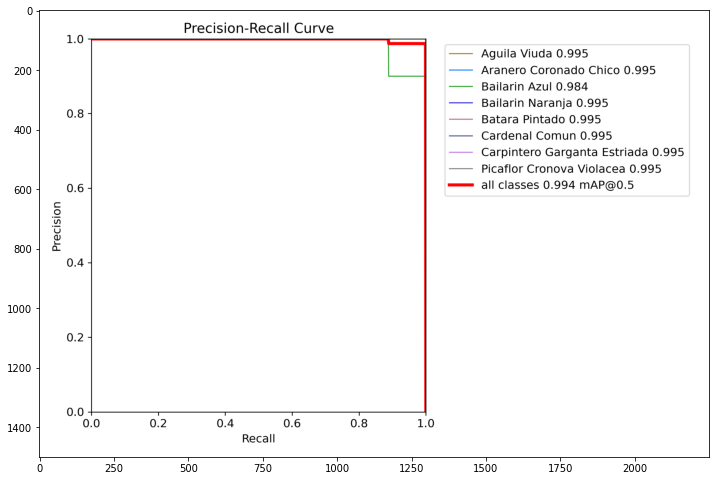

In [ ]:
I = cv2.imread('runs/val/exp2/PR_curve.png')  # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(I)
plt.show()

## Despliegue de resultados

Imágenes con detecciones incrustadas por YOLO, o incrustaciones manuales a partir de la salida de las clases.

In [52]:
def plot_boundingbox(iname,img_path,label_path):
    img_name = img_path +'/'+iname
    print('image:',img_name)
    X = cv2.imread(img_name)
    N = X.shape[0]
    M = X.shape[1]
    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
    plt.title(iname)
    lname = label_path+iname[:-4]+'.txt'
    print(' bbox:',lname)
    if os.path.isfile(lname):
        arr = np.loadtxt(lname)
        if len(arr.shape)==1:
            n = 1
        else:
            n = arr.shape[0]
        for k in range(n):
            if n>1:
                z = arr[k,:]
            else:
                z = arr
            cl = int(z[0]) # object class
            x = z[1]*M
            y = z[2]*N
            w2 = z[3]*M/2
            h2 = z[4]*N/2
            x1 = x-w2
            x2 = x+w2
            y1 = y-h2
            y2 = y+h2
            try:
                p = z[5]
                plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'g')
                plt.text(x1,y1,"{} - {}".format(str(class_names[cl]), p),bbox=dict(facecolor='red', alpha=0.5))
            except:
                # Se guardaron etiquetas sin probabilidad
                # O se está leyendo un archivo de etiqueta manual
                plt.plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'g')
                plt.text(x1,y1,str(class_names[cl]),bbox=dict(facecolor='red', alpha=0.5))
    plt.show()


In [63]:
%cd yolov5

/content/yolov5


In [64]:
tpath = '../data/images/test/'
lpath = '../data/labels/test/'
img_names = dirfiles(tpath,'*.jpg')
i = 0

image: runs/detect/exp3/DJI_0102_3.jpg
 bbox: ../data/labels/test/DJI_0102_3.txt


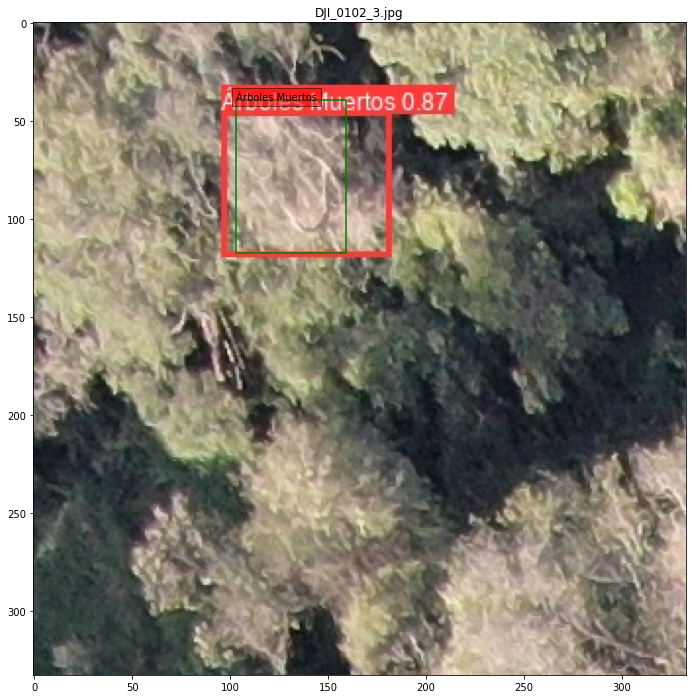

In [39]:
i = 10 # Indice para ver alguna en específico
# Acá las imágenes tienen el box incrustado por la red, abajo no. Lo ponemos nosotros.
iname = img_names[i]
img_path = 'runs/detect/exp3' # ver path en las ultimas lineas de la ejecución de 'deteccion en testing'
label_path = lpath
plot_boundingbox(iname, img_path, label_path)

In [51]:
from random import randint
import cv2


img_path = 'runs/detect/exp3' # ver path en las ultimas lineas de la ejecución de 'deteccion en testing'
label_path = lpath

LIMIT = 20

for i in range(LIMIT):
    try:
      iname = img_names[randint(0,len(img_names))]
      plot_boundingbox(iname, img_path, label_path)
    except:
      print("Omitiendo, sin etiquetas")

image: runs/detect/exp3/DJI_0104_66.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0113_24.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0103_85.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0110_81.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0109_61.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0104_47.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0106_39.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0108_83.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0113_36.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0113_47.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0112_85.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0112_44.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0111_105.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0107_3.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/DJI_0113_39.jpg
Omitiendo, sin etiquetas
image: runs/detect/exp3/D

In [74]:
cd

/root


In [83]:
!zip -r "/results_final.zip" "../yolov5/runs"

  adding: ../yolov5/runs/ (stored 0%)
  adding: ../yolov5/runs/detect/ (stored 0%)
  adding: ../yolov5/runs/detect/exp2/ (stored 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0113_32.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0104_66.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0112_30.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0110_7.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0108_94.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0111_39.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0109_30.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0102_89.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0113_36.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0102_78.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0104_46.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0108_20.jpg (deflated 0%)
  adding: ../yolov5/runs/detect/exp2/DJI_0105_95.jpg (deflated 0

In [47]:
cd

/root


image: ../data/images/test//DJI_0103_66.jpg
 bbox: ../data/labels/test/DJI_0103_66.txt


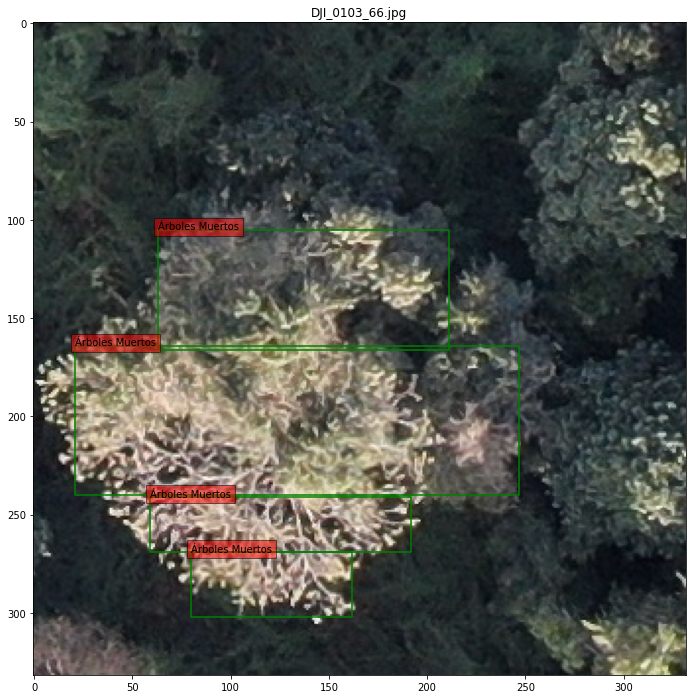

In [72]:
iname = dirfiles('runs/detect/exp3/', 'DJI_0103_66.jpg')
img_path = '../data/images/test/'
label_path = '../data/labels/test/' # ver path en las ultimas lineas de la ejecución anterior
plot_boundingbox(iname[0],img_path,label_path)

## Detección en imágenes de prueba nuevas

Se carga en nuevo directorio la(s) imagen(es) a probar y se corre `detect.py` como se corrió en uno de los pasos anteriores:

In [ ]:
%cd ..

/content


In [ ]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Version Online
!wget https://github.com/AxelSkrauba/Taller_IA/raw/main/3_RNA_TransferLearning/OnlyTest_byGoogle.zip

--2022-08-24 03:25:30--  https://github.com/AxelSkrauba/Taller_IA/raw/main/3_RNA_TransferLearning/OnlyTest_byGoogle.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AxelSkrauba/Taller_IA/main/3_RNA_TransferLearning/OnlyTest_byGoogle.zip [following]
--2022-08-24 03:25:30--  https://raw.githubusercontent.com/AxelSkrauba/Taller_IA/main/3_RNA_TransferLearning/OnlyTest_byGoogle.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17612926 (17M) [application/zip]
Saving to: ‘OnlyTest_byGoogle.zip’

OnlyTest_byGoogle.z 100%[===================>]  16.80M  --.-KB/s    in 0.04s   

2022-08-24 03:25:

In [ ]:
!unzip OnlyTest_byGoogle.zip

In [ ]:
%cd yolov5

/content/yolov5


In [49]:
NEW_PATH_TEST = '../OnlyTest_byGoogle'
TEST_IMAGE    = 'DJI_0103_66.jpg'

In [ ]:
!python detect.py --weights {TEST_WEIGHTS} --img 350 --conf 0.5 --source  {NEW_PATH_TEST} --save-txt  --save-conf

detect: weights=['runs/train/exp/weights/last.pt'], source=../OnlyTest_byGoogle, data=data/coco128.yaml, imgsz=[350, 350], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-51-ge6f54c5 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20881221 parameters, 0 gradients, 47.9 GFLOPs
image 1/232 /content/OnlyTest_byGoogle/AguilaViuda1.jpg: 256x352 (no detections), 14.7ms
image 2/232 /content/OnlyTest_byGoogle/AguilaViuda10.jpg: 352x352 (no detections), 14.7ms
image 3/232 /content/OnlyTest_byGoogle/AguilaViuda11.jpg: 256x352 1 Aguila Viuda, 12.6ms
image 4/232 /content/OnlyTest_byGoogle/AguilaViuda12.jpg: 256x352 1 Aguila Viuda, 12.5ms
ima

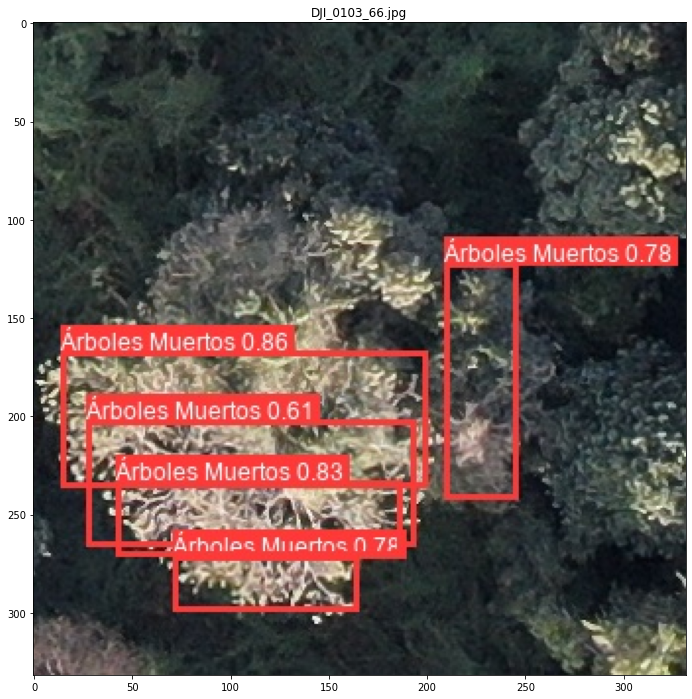

In [65]:
X = cv2.imread('runs/detect/exp3/'+TEST_IMAGE) # ver path en las ultimas lineas de la ejecución anterior
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
plt.title(TEST_IMAGE)
plt.show()

image: ../OnlyTest_byGoogle/AraneroCoronadoChico51.jpg
 bbox: runs/detect/exp2/labels/AraneroCoronadoChico51.txt


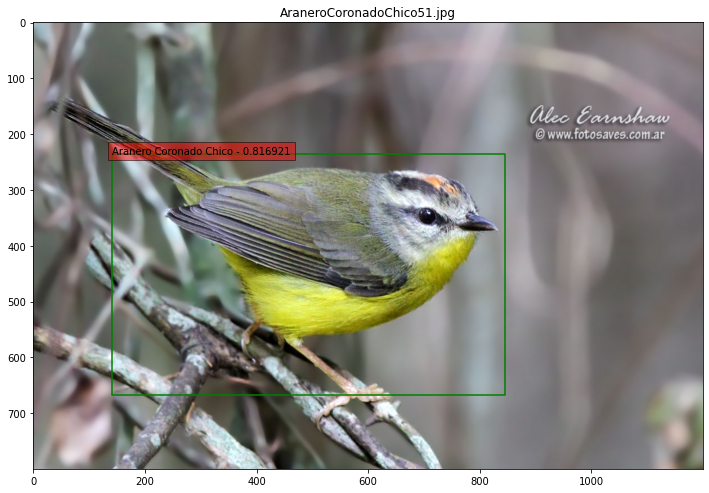

In [ ]:
label_path = 'runs/detect/exp2/labels/' # ver path en las ultimas lineas de la ejecución anterior
plot_boundingbox(TEST_IMAGE, NEW_PATH_TEST, label_path)

### Visualización en lote del resultado

Charlamos sobre resultados, contextos, alcance del modelo y diferentes porqués...

In [ ]:
from random import randint
import cv2


tpath = '../OnlyTest_byGoogle/'
img_names = dirfiles(tpath,'*.jpg')

LIMIT = 10

for i in range(LIMIT):
    img = img_names[randint(0,len(img_names))]
    X = cv2.imread('runs/detect/exp2/'+img) # ver path en las ultimas lineas de la ejecución anterior
    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(X, cv2.COLOR_BGR2RGB))
    plt.title(img)
    plt.show()
